# Before you start the HW3, please read HW3.pdf!

## Problem 1


<img src="https://learnopencv.com/wp-content/uploads/2023/01/YOLO_8_Feature_768x432.gif" width="500">

In this homework assignment, we will use YOLOv8 (ultralytics) to help us to do the tasks of detection, tracking, pose estimation, and segmentation.

Ultralytics YOLOv8 is a cutting-edge, state-of-the-art (SOTA) model that builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility. YOLOv8 is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and tracking, instance segmentation, image classification and pose estimation tasks.


### Getting Started

In [1]:
# First step, let's install ultralytics first!
# install dependencies:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.4/112.6 GB disk)


In [2]:
# fix file path in google colab
from google.colab import drive
drive.mount('/content/drive')

# change path
import os
os.chdir('/content/drive/MyDrive/HW3')

Mounted at /content/drive


### Run a pretrained YOLOv8n model

In [ ]:
from ultralytics import YOLO
import requests
from PIL import Image
from io import BytesIO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model

# TODO
# predict on your own image (you can randomly grab an image from internet)
url = "https://stpaulpet.com/wp-content/uploads/dog-facts-cat-facts.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# predict
results = model(img)


0: 480x640 2 dogs, 1 sheep, 42.6ms
Speed: 2.4ms preprocess, 42.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


### Visualize the predict image

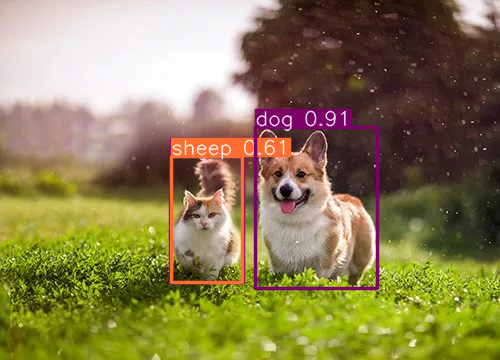

In [ ]:
from PIL import Image

# display
results[0].show()

AWESOME!!! Great progress so far! We are able to detect person, stopsign, and bus! At this point, we have used the pre-trained model to do the inference on the given image.

The model we just used is `YOLOv8n`(YOLOv8 nano). Actually, YOLOv8 provides us more than that, you may find great amounts of models for different tasks in the given [MODEL_ZOO](https://github.com/ultralytics/ultralytics/blob/main/README.md#models). What about we try a different model to see what its output will look like?


* Q1 (5%): Object Detection. Use the same YOLOv8n model, with confidence score of 0.9 (`conf=0.9`), to run inference on your image and see if you can get detection.

* Q2 (5%): After you get the prediction, visualize the image with predict bounding box.

* Q3 (5%): Instance Segmentation. Go to the [MODEL_ZOO](https://github.com/ultralytics/ultralytics/blob/main/README.md#models) and scroll down to the `segmentation` section. Choose one of the pose estimation model and inference on `your custom image (you can grab some random image from the internet)`, and then visualize the results.

* Q4 (5%): Human Pose Estimation. Go to the [MODEL_ZOO](https://github.com/ultralytics/ultralytics/blob/main/README.md#models) and scroll down to the `pose` section. Choose one of the pose estimation model and inference on `your custom image (you can grab some random image from the internet)`, and then visualize the results.

In [ ]:
# TODO: Q1
# predict with conf=0.9
results = model(img, conf=0.9)


0: 480x640 1 dog, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


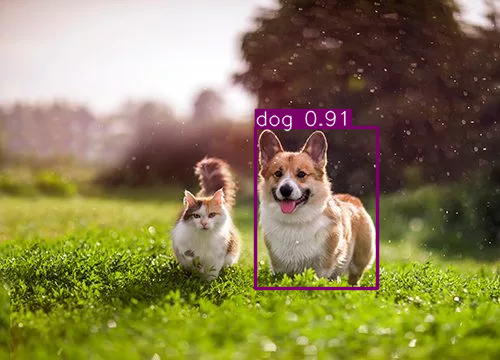

In [ ]:
# TODO: Q2
# display
results[0].show()


0: 480x640 1 bird, 1 sheep, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 11.0ms postprocess per image at shape (1, 3, 480, 640)


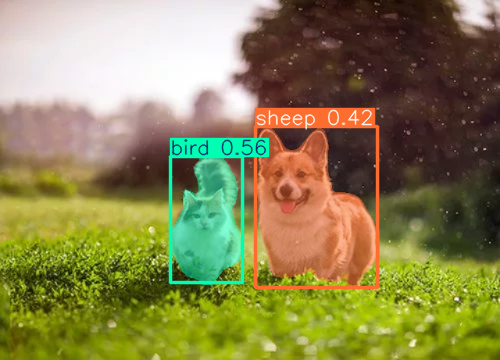

In [ ]:
# TODO: Q3
# segmentation, use yolov8-seg.pt
model = YOLO("yolov8n-seg.pt")
results = model(img)
results[0].show()


0: 448x640 5 persons, 65.4ms
Speed: 3.3ms preprocess, 65.4ms inference, 36.5ms postprocess per image at shape (1, 3, 448, 640)


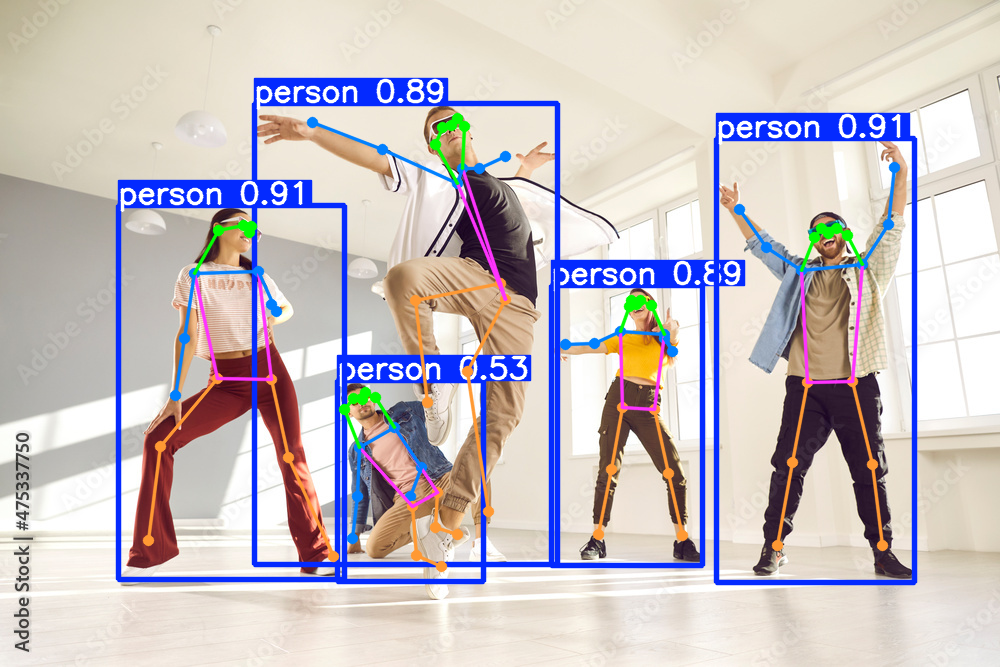

In [ ]:
# TODO: Q4
# pose estimation, use yolov8n-pose.pt
model = YOLO("yolov8n-pose.pt")

# load image
url = "https://as2.ftcdn.net/v2/jpg/04/75/33/77/1000_F_475337750_EdUDu470bT5ztQfBsJnn6MBGdX44iH7I.jpg" # people dancing
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# predict and display
results = model(img)
results[0].show()

## Problem 2
Train a model based on the SportsMOT dataset.  
Now, we want to train a model based on one of the sequence in the SportsMOT dataset, and then conduct multi-object tracking (Problem 3).

#### 1. label conversion
The file in dataset/train/gt/gt.txt follows the MOT format, which is frame_id,track_id,x,y,w,h,1,1,1  

We need to modify it into YOLOv8 training format, which is class_id,center_x,center_y,w,h (where all of them need to be normalized, besides class_id)

In [ ]:
import numpy as np

img_w = 1280
img_h = 720

splits = {'train','test'}
for split in splits:
    labels = np.loadtxt(f'dataset/{split}/gt/gt.txt',dtype=int,delimiter=',')
    start_frame = labels[0][0]
    last_frame = labels[-1][0]
    for frame_id in range(start_frame,last_frame+1):
        frame_label = labels[labels[:,0]==frame_id]
        frame_output_file = []
        for _,_,x,y,w,h,_,_,_ in frame_label:
            center_x = round((x+w//2)/img_w,3)
            center_y = round((y+h//2)/img_h,3)
            normalize_w = round(w/img_w,3)
            normalize_h = round(h/img_h,3)
            frame_output_file.append(f'0 {center_x} {center_y} {normalize_w} {normalize_h}') # YOLOv8 format (class center_x center_y w h)

        with open(f'dataset/{split}/labels/{"%06d"%frame_id}.txt','w') as f:
            for line in frame_output_file:
                f.writelines(line+'\n')

Q1 (15%): Follow the Usage Examples [here](https://docs.ultralytics.com/modes/train/#key-features-of-train-mode) and use the modified config to train the model for some epochs. (You decide which size of model, how many epochs, check the validation performance and see if the accuracy looks good!)

You can use any size of YOLOv8 model, although a larger model might results in higher detection accuracy, it might takes more time to run tracking in problem 3 due to the computational cost.

In [ ]:
# TODO
# train the model

# dataset_location = "/content/drive/MyDrive/EEP568_HW3/dataset"
model = YOLO("yolov8n.pt")
results = model.train(data="/content/drive/MyDrive/EEP568_HW3/dataset/config.yaml", epochs=20, imgsz=640, batch=16, verbose=True, name="yolov8n_sportsmot")



Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/EEP568_HW3/dataset/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_sportsmot2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/EEP568_HW3/dataset/train/labels.cache... 725 images, 0 backgrounds, 0 corrupt: 100%|██████████| 725/725 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/EEP568_HW3/dataset/test/labels.cache... 1197 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1197/1197 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sportsmot2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_sportsmot2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.56G      1.288      1.593     0.9087        103        640: 100%|██████████| 46/46 [01:14<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:10<00:00,  6.58s/it]


                   all       1197      16229      0.972      0.453      0.906      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.75G      1.112     0.7287     0.8691         84        640: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


                   all       1197      16229      0.964      0.935      0.968      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.78G      1.096     0.6817      0.864         79        640: 100%|██████████| 46/46 [00:35<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


                   all       1197      16229      0.966      0.954       0.97      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.98G      1.058     0.6373     0.8542         96        640: 100%|██████████| 46/46 [00:34<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]


                   all       1197      16229      0.962      0.958      0.977       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.49G     0.9906     0.5929     0.8484        137        640: 100%|██████████| 46/46 [00:25<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


                   all       1197      16229      0.963      0.953      0.967      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.77G     0.9735     0.5646     0.8425        122        640: 100%|██████████| 46/46 [00:33<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


                   all       1197      16229      0.958      0.955      0.974      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.61G     0.9301     0.5375     0.8371        104        640: 100%|██████████| 46/46 [00:30<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:28<00:00,  1.36it/s]


                   all       1197      16229      0.972      0.958      0.971      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.91G     0.9064     0.5251     0.8337         85        640: 100%|██████████| 46/46 [00:20<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:24<00:00,  1.56it/s]


                   all       1197      16229      0.975      0.966      0.976       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.89G     0.8863     0.5058     0.8317        126        640: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:29<00:00,  1.28it/s]


                   all       1197      16229      0.979      0.962       0.98      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.54G     0.8957     0.5019     0.8301        160        640: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:25<00:00,  1.48it/s]


                   all       1197      16229      0.976      0.966      0.982      0.763
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.8096     0.4915     0.8239         66        640: 100%|██████████| 46/46 [00:21<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


                   all       1197      16229      0.977      0.961      0.979      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.24G     0.8086     0.4718     0.8258         70        640: 100%|██████████| 46/46 [00:19<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]


                   all       1197      16229      0.969      0.966      0.975      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.24G     0.7808     0.4542     0.8205         67        640: 100%|██████████| 46/46 [00:19<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


                   all       1197      16229      0.974      0.969      0.981      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.24G     0.7772      0.448     0.8198         63        640: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


                   all       1197      16229      0.977      0.962      0.976      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.23G     0.7674     0.4373     0.8156         61        640: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


                   all       1197      16229      0.974      0.966      0.976      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.23G      0.756     0.4268     0.8167         55        640: 100%|██████████| 46/46 [00:18<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]

                   all       1197      16229      0.979      0.969      0.979      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.23G     0.7465     0.4177     0.8118         63        640: 100%|██████████| 46/46 [00:19<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


                   all       1197      16229      0.976      0.962      0.976      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.23G     0.7308     0.4045     0.8124         67        640: 100%|██████████| 46/46 [00:18<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


                   all       1197      16229      0.979      0.966      0.977      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.23G     0.7226     0.3984     0.8092         65        640: 100%|██████████| 46/46 [00:19<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]

                   all       1197      16229      0.979      0.966      0.977      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.23G     0.7084     0.3904     0.8109         72        640: 100%|██████████| 46/46 [00:18<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]

                   all       1197      16229      0.979      0.966      0.978      0.793



20 epochs completed in 0.356 hours.
Optimizer stripped from runs/detect/yolov8n_sportsmot2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sportsmot2/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sportsmot2/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


                   all       1197      16229      0.979      0.967      0.977      0.793
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/yolov8n_sportsmot2


In [ ]:
# # download best.pt
# from google.colab import files
# files.download('runs/detect/yolov8n_sportsmot/weights/best.pt')

Q2 (5%): Now load the trained model and inference on one of the test image. Remember to visualize the results.


0: 384x640 21 persons, 37.2ms
Speed: 1.9ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


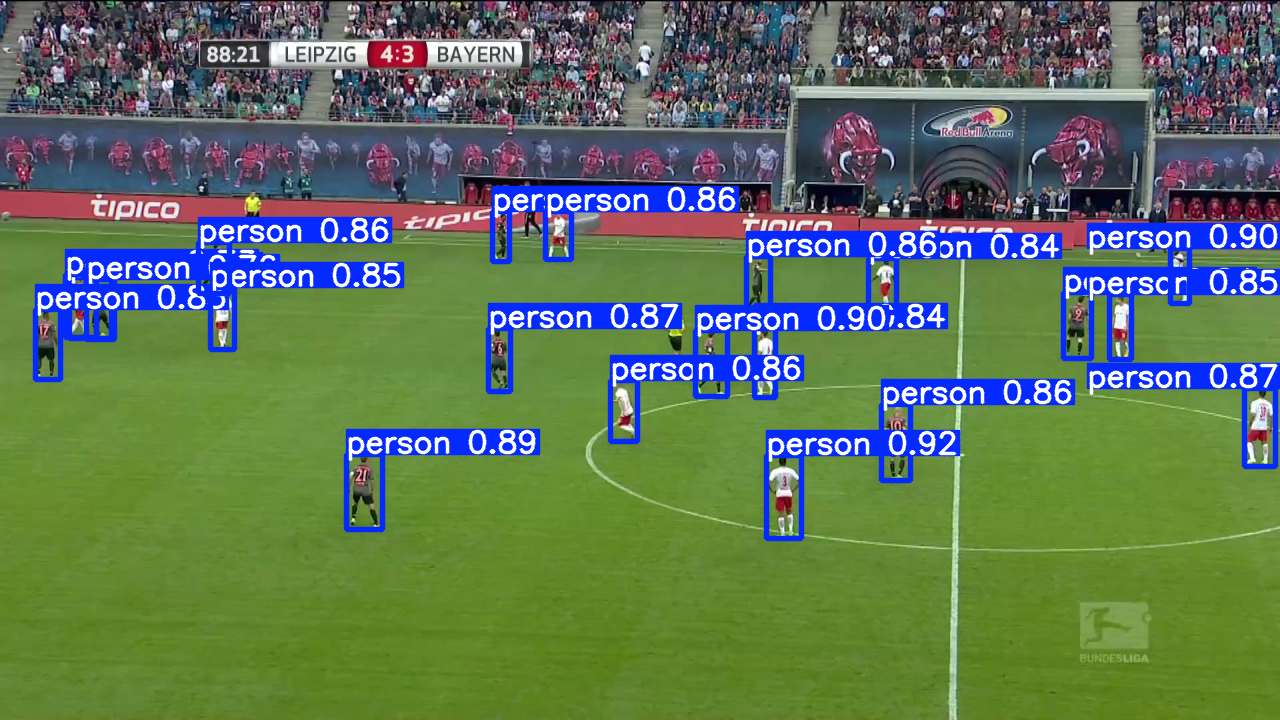

In [ ]:
# TODO
# load trained model
trained_model_path = "runs/detect/yolov8n_sportsmot/weights/best.pt"
model = YOLO(trained_model_path)

# load one image
img = Image.open("dataset/test/images/000001.jpg")

# predict and display
results = model(img)
results[0].show()

## Problem 3 (See the grading weights in HW3.pdf)

Multi-Object Tracking  

After training the detector, now we want to implement tracking on the testing video.

We provide a simple baseline here, but it's not necessary to run this.

You can run other opensource tracker if you want to, but please include the code in here

## 3(a) Optional - Baseline implementation

In [ ]:
# Let's start with a detector class
from ultralytics import YOLO
from PIL import Image
class detector:
    def __init__(self,model,conf_threshold=0.7,iou=0.7):
        self.model = YOLO(model)
        self.conf = conf_threshold
        self.iou = iou

    def predict(self,img):
        pred = self.model(img,conf=self.conf,iou=self.iou,verbose=False,save=False)
        pred = pred[0].boxes.data.tolist()
        return pred


# TODO
# Load your trained model and inference on the first image in the test set ('dataset/test/images/000001.jpg') and print the model prediction.
# The output format should be x1,y1,x2,y2,score,class

trained_model_path = "runs/detect/yolov8n_sportsmot/weights/best.pt"
det = detector(model=trained_model_path)

# load one image
img = Image.open("dataset/test/images/000001.jpg")

# run inference
predictions = det.predict(img)

for box in predictions:
    print(f"x1: {box[0]}, y1: {box[1]}, x2: {box[2]}, y2: {box[3]}, score: {box[4]}, class: {box[5]}")

x1: 766.49560546875, y1: 455.314208984375, x2: 801.34375, y2: 538.4171142578125, score: 0.9188026785850525, class: 0.0
x1: 1170.31591796875, y1: 248.4239501953125, x2: 1189.70458984375, y2: 303.89111328125, score: 0.9022533893585205, class: 0.0
x1: 695.7734375, y1: 330.80023193359375, x2: 727.76904296875, y2: 396.77337646484375, score: 0.8954858779907227, class: 0.0
x1: 346.61669921875, y1: 454.9105224609375, x2: 382.85791015625, y2: 529.520263671875, score: 0.8945829272270203, class: 0.0
x1: 488.47235107421875, y1: 328.41827392578125, x2: 510.7684326171875, y2: 391.80169677734375, score: 0.8699848651885986, class: 0.0
x1: 1244.601318359375, y1: 388.63702392578125, x2: 1275.490478515625, y2: 466.08868408203125, score: 0.8692721128463745, class: 0.0
x1: 610.0155029296875, y1: 380.9227600097656, x2: 637.0699462890625, y2: 441.2346496582031, score: 0.8625041842460632, class: 0.0
x1: 545.41162109375, y1: 211.11495971679688, x2: 571.982421875, y2: 259.8264465332031, score: 0.861349523067474

Now you will implement your own tracker!  

Let's start with the IoU function and tracklet class.

In [ ]:
# calculate the overlap ratio of two bounding boxes
def calculate_iou(bbox1, bbox2):

    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    area_bbox1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area_bbox2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    iou = intersection_area / float(area_bbox1 + area_bbox2 - intersection_area)

    return iou

In [ ]:
# base class for tracklet, you can of course add more features and try to improve the performance!
class tracklet:
    def __init__(self,tracking_ID,box):
        self.ID = tracking_ID
        self.cur_box = box
        self.alive = True

    def update(self,box):
        self.cur_box = box

    def close(self):
        self.alive = False

In [ ]:
from scipy.optimize import linear_sum_assignment
import numpy as np

class IoU_Tracker:
    def __init__(self):
        self.all_tracklets = [] # this saves all the tracklets so that we can know how many tracklets we have
        self.cur_tracklets = [] # this saves tracklets from the last frame for current frame's association
        self.online_tracklets = [] # this saves the tracklets after association, so we can pass the tracking result to output

    def update(self,frame_id,detection):

        if frame_id%100 == 0:
            print(f'Running tracking || current frame {frame_id}')

        if len(self.cur_tracklets) == 0: # no current tracklets
            for det in detection:
                new_tracklet = tracklet(len(self.all_tracklets)+1,det[0:4])
                self.cur_tracklets.append(new_tracklet)
                self.all_tracklets.append(new_tracklet)
        else:
            cost_matrix = np.zeros((len(self.cur_tracklets),len(detection)))

            # build up cost matrix, each element in cost matrix should be 1-IoU between tracklet and detection
            for row in range(len(self.cur_tracklets)):
                for col in range(len(detection)):
                    cost_matrix[row][col] = 1 - calculate_iou(self.cur_tracklets[row].cur_box,detection[col][0:4])

            row_inds,col_inds = linear_sum_assignment(cost_matrix)

            matches = min(len(row_inds),len(col_inds))

            # TODO
            # if tracklet in self.cur_tracklets is not matched in the above Hungarian algorithm stage
            # use tracklet's close function to kill those unmatched tracklets
            for idx,trk in enumerate(self.cur_tracklets):
                # pass
                if idx not in row_inds:
                    trk.close()

            # TODO
            # initiate unmatched detections as new tracklets
            for idx,det in enumerate(detection):
                if idx not in col_inds: # if it is not matched in the above Hungarian algorithm stage
                    # pass
                    new_tracklet = tracklet(len(self.all_tracklets) + 1, det[0:4])
                    self.cur_tracklets.append(new_tracklet)
                    self.all_tracklets.append(new_tracklet)

            for idx in range(matches):
                row,col = row_inds[idx],col_inds[idx]
                if cost_matrix[row][col] == 1:
                    # TODO 1. Kill the tracklet using tracklet's close function
                    # TODO 2. Initiate a new tracklet for the new detection
                    # TODO 3. Append new tracklet to the current tracklets and all tracklets
                    # pass
                    self.cur_tracklets[row].close()
                    new_tracklet = tracklet(self.cur_tracklets[row].ID, detection[col][0:4])
                    self.cur_tracklets.append(new_tracklet)
                    self.all_tracklets.append(new_tracklet)
                else:
                    # pass
                    # update tracklet with new detection
                    self.cur_tracklets[row].update(detection[col][0:4])

        self.cur_tracklets = [trk for trk in self.cur_tracklets if trk.alive]

        return self.cur_tracklets

Now it's time to run tracking!

In [ ]:
import glob

# TODO
# initialize your detector (the one you just trained)
trained_model_path = "runs/detect/yolov8n_sportsmot/weights/best.pt"
model = detector(model = trained_model_path, conf_threshold = 0.5, iou = 0.3)

# TODO
# initialize tracker
tracker = IoU_Tracker()

# TODO run tracking

images = sorted(glob.glob('dataset/test/images/*'))
results = []

print(f'length of sequence is {len(images)}')

for frame_id, img in enumerate(images,1):
    # TODO get detection with your model
    detections = model.predict(img)

    # TODO update tracker with detection
    result = tracker.update(frame_id, detections)

    for track in result:
        x1,y1,x2,y2 = track.cur_box
        track_id = track.ID
        results.append(f'{int(frame_id)},{int(track_id)},{int(x1)},{int(y1)},{int(x2-x1)},{int(y2-y1)},{1},{1},{1}') # format: frame_id, track_id, x, y, w, h, score, x_coord, y_coord

with open('results.txt','w') as f:
    for line in results:
        f.writelines(line)
        f.writelines('\n')

length of sequence is 1197
Running tracking || current frame 100
Running tracking || current frame 200
Running tracking || current frame 300
Running tracking || current frame 400
Running tracking || current frame 500
Running tracking || current frame 600
Running tracking || current frame 700
Running tracking || current frame 800
Running tracking || current frame 900
Running tracking || current frame 1000
Running tracking || current frame 1100


# 3(b) Evaluation

Some packages are required to do the evaluation and visualization

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install motmetrics
!pip install pytrec_eval
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp310-cp310-linux_x86_64.whl size=308202 sha256=c1e1a8ae5688c10f515d048b4ba6bad17090a7bfb4e052f562e52c8b19ee5eb8
  Stored in directory: /root/.cache/pip/wheels/51/3a/cd/dcc1ddfc763987d5cb237165d8ac249aa98a23ab90f67317a8
Successfully built pytrec_eval


Now you can evaluate the tracking results using the standard MOT CLEAR Metrics.

In [ ]:
# Evaluate your tracking performance
!python eval.py dataset/test/gt/gt.txt results.txt

          IDF1   IDP   IDR   idtp   idfp   idfn  MOTA  MOTP  Rcll  Prcn IDs MT PT ML
MultiCam 51.71 52.27 51.16 8302.0 7580.0 7927.0 93.95 11.63 96.28 98.38 121 22  0  0


Can you try to improve the performance with differnet tracking tricks? Here, we provide several potential tricks to increase the tracking performance, including:
1. Use a larger detector to get better detection.
2. Using a lower confidence threshold in detector - some low score detections that is filtered might be false negative detections! (or switch to a higher threshold if you have too many false positive)
3. Use different association strategy, for example a different IoU? or use bounding box distance for association?
4. Maybe try some opensource tracking method? Try to use the SOTA tracker on SportsMOT dataset!

Please include your experiment results in your report!! We give grade based on performance (ranking) and also your report.

In [ ]:
# visualize the tracking result
!python vis.py

Saving video at test_visualization.avi
processing frame:  500
processing frame:  1000


Additional try: use deep_eiou opensourse tracking method

In [5]:
# !git clone https://github.com/hsiangwei0903/Deep-EIoU.git
import sys
sys.path.append('/content/drive/MyDrive/HW3/Deep-EIoU/')

Cloning into 'Deep-EIoU'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 455 (delta 12), reused 2 (delta 1), pack-reused 400 (from 1)
Receiving objects: 100% (455/455), 36.87 MiB | 11.65 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Updating files: 100% (377/377), done.


In [9]:
%cd /content/drive/MyDrive/HW3/Deep-EIoU/Deep-EIoU/reid
!pip install -r requirements.txt
!pip install cython_bbox
!python setup.py develop
!cd ..

/content/drive/MyDrive/HW3/Deep-EIoU/Deep-EIoU/reid
  Using cached loguru-0.7.2-py3-none-any.whl.metadata (23 kB)
  Using cached mccabe-0.7.0-py2.py3-none-any.whl.metadata (5.0 kB)
  Using cached pycodestyle-2.12.1-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached pyflakes-3.2.0-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.8 MB/s eta 0:00:00
Using cached mccabe-0.7.0-py2.py3-none-any.whl (7.3 kB)
Using cached pycodestyle-2.12.1-py2.py3-none-any.whl (31 kB)
Using cached pyflakes-3.2.0-py2.py3-none-any.whl (62 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchreid 1.4.0 requires lap, which is not installed.
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is d

In [10]:
# print device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# run demo.py
%cd /content/drive/MyDrive/HW3/Deep-EIoU/Deep-EIoU
!python tools/demo.py

/content/drive/MyDrive/HW3/Deep-EIoU/Deep-EIoU
2024-11-10 17:32:24.016 | INFO     | __main__:main:296 - Args: Namespace(experiment_name='yolox_x_ch_sportsmot', name=None, path='/content/drive/MyDrive/HW3/dataset/test/', save_result=True, exp_file='yolox/yolox_x_ch_sportsmot.py', ckpt=None, device=device(type='cuda'), conf=None, nms=None, tsize=None, fps=30, fp16=False, fuse=False, trt=False, track_high_thresh=0.6, track_low_thresh=0.1, new_track_thresh=0.7, track_buffer=60, match_thresh=0.8, aspect_ratio_thresh=1.6, min_box_area=10, nms_thres=0.7, mot20=False, with_reid=True, proximity_thresh=0.5, appearance_thresh=0.25)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-11-10 17:32:26.080 | INFO     | __main__:main:306 - Mo

In [14]:
# post-process the output file
input_file_path = '/content/drive/MyDrive/HW3/Deep-EIoU/Deep-EIoU/YOLOX_outputs/yolox_x_ch_sportsmot/track_vis/2024_11_10_17_32_28.txt' # modify when needed
output_file_path = '/content/drive/MyDrive/HW3/results_deep_eiou.txt'

with open(input_file_path, 'r') as file:
    lines = file.readlines()

modified_lines = []
for line in lines:
    parts = line.strip().split(',')
    parts[0] = str(int(parts[0]) + 1)  # frame+1
    # Set the last three columns to 1
    parts[-1] = '1'
    parts[-2] = '1'
    parts[-3] = '1'
    del parts[-4] # remove score
    modified_lines.append(','.join(parts))

# write to new file
with open(output_file_path, 'w') as file:
    for modified_line in modified_lines:
        file.write(modified_line + '\n')

print(f"Modified data saved to {output_file_path}.")

Modified data saved to /content/drive/MyDrive/HW3/results_deep_eiou.txt.


In [15]:
# Evaluate your tracking performance
%cd /content/drive/MyDrive/HW3
!python eval.py dataset/test/gt/gt.txt results_deep_eiou.txt

/content/drive/MyDrive/HW3
          IDF1   IDP   IDR    idtp   idfp   idfn  MOTA MOTP  Rcll  Prcn IDs MT PT ML
MultiCam 81.13 81.50 80.75 13105.0 2974.0 3124.0 98.68 5.98 98.96 99.88  27 22  0  0
